## Load and preproceess the data

In [4]:
import pandas as pd
import numpy as np

# Custom normalization function
def custom_normalize(df, feature_ranges):
    """
    Normalize specified columns according to given [min, max] ranges.
    
    :param df: Original DataFrame
    :param feature_ranges: Dictionary format, e.g. {'x1': (580, 680), 'x2': (220, 300)}
    :return: Normalized DataFrame
    """
    normalized_df = df.copy()
    for col, (min_val, max_val) in feature_ranges.items():
        normalized_df[col] = (df[col] - min_val) / (max_val - min_val)
    return normalized_df

# Load data from Excel file
data = pd.read_excel('Initial_data2.xlsx', sheet_name='Bayes')

# Define input features and target column
features = ['x1', 'x2', 'x3', 'x4', 'x5']
target_col = 'y1'

# Split features and target variable
X = data[features]
y = data[target_col]

# Apply custom normalization based on specified ranges
feature_ranges = {
    'x1': (580, 680),
    'x2': (220, 300),
    'x3': (0.025, 0.15),
    'x4': (0.01, 0.04),
    'x5': (0.0, 1.0)  # Example: assuming x5 range is [0, 1]
}

X = custom_normalize(X, feature_ranges)

# Define feature names for later use (e.g., model interpretation or visualization)
feature_names = ['x1', 'x2', 'x3', 'x4', 'x5']

# 评估RMSE,MAE,R2

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Function to train and evaluate the model using repeated cross-validation
def train_evaluate_model(model, model_name, X, y, num_repeats=5, num_folds=5):
    """
    Trains and evaluates a model using repeated K-Fold cross-validation.
    
    :param model: Model object (e.g., from scikit-learn)
    :param model_name: Name of the model (string)
    :param X: Feature data
    :param y: Target variable
    :param num_repeats: Number of repetitions for cross-validation
    :param num_folds: Number of folds per repetition
    :return: Dictionary containing evaluation metrics
    """
    
    # Initialize lists to store results
    all_r2_train = []
    all_rmse_train = []
    all_mae_train = []
    all_r2_test = []
    all_rmse_test = []
    all_mae_test = []

    all_y_train = []
    all_y_train_pred = []
    all_y_test = []
    all_y_test_pred = []
    all_x_train = []
    all_x_test = []

    # Perform repeated cross-validation
    for i in range(num_repeats):
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=i)
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Store results
            all_y_train.append(y_train)
            all_y_train_pred.append(y_train_pred)
            all_y_test.append(y_test)
            all_y_test_pred.append(y_test_pred)
            all_x_train.append(X_train)
            all_x_test.append(X_test)

            # Calculate evaluation metrics
            all_r2_train.append(r2_score(y_train, y_train_pred))
            all_rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            all_mae_train.append(mean_absolute_error(y_train, y_train_pred))

            all_r2_test.append(r2_score(y_test, y_test_pred))
            all_rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            all_mae_test.append(mean_absolute_error(y_test, y_test_pred))

    # Concatenate all true and predicted values
    y_train_combined = np.concatenate(all_y_train)
    y_train_pred_combined = np.concatenate(all_y_train_pred)
    y_test_combined = np.concatenate(all_y_test)
    y_test_pred_combined = np.concatenate(all_y_test_pred)

    x_train_combined = np.concatenate(all_x_train)
    x_test_combined = np.concatenate(all_x_test)

    # Compute mean and standard deviation of metrics
    metrics = {
        'model_name': model_name,
        'train_r2_mean': np.mean(all_r2_train),
        'train_r2_std': np.std(all_r2_train),
        'train_rmse_mean': np.mean(all_rmse_train),
        'train_rmse_std': np.std(all_rmse_train),
        'train_mae_mean': np.mean(all_mae_train),
        'train_mae_std': np.std(all_mae_train),

        'test_r2_mean': np.mean(all_r2_test),
        'test_r2_std': np.std(all_r2_test),
        'test_rmse_mean': np.mean(all_rmse_test),
        'test_rmse_std': np.std(all_rmse_test),
        'test_mae_mean': np.mean(all_mae_test),
        'test_mae_std': np.std(all_mae_test),
    }

    # Print performance summary
    print(f"\n=== {model_name} Performance ===")
    print(f"Train R² Mean: {metrics['train_r2_mean']:.4f}, Std: {metrics['train_r2_std']:.4f}")
    print(f"Train RMSE Mean: {metrics['train_rmse_mean']:.4f}, Std: {metrics['train_rmse_std']:.4f}")
    print(f"Train MAE Mean: {metrics['train_mae_mean']:.4f}, Std: {metrics['train_mae_std']:.4f}")
    print(f"Test R² Mean: {metrics['test_r2_mean']:.4f}, Std: {metrics['test_r2_std']:.4f}")
    print(f"Test RMSE Mean: {metrics['test_rmse_mean']:.4f}, Std: {metrics['test_rmse_std']:.4f}")
    print(f"Test MAE Mean: {metrics['test_mae_mean']:.4f}, Std: {metrics['test_mae_std']:.4f}")

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_combined, y_train_pred_combined, color='blue', label='Training Set', alpha=0.6)
    plt.scatter(y_test_combined, y_test_pred_combined, color='red', label='Test Set', alpha=0.6)
    plt.plot([y_train_combined.min(), y_train_combined.max()],
             [y_train_combined.min(), y_train_combined.max()],
             color='green', linestyle='--', label='Ideal Line')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save prediction results into DataFrames
    train_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_train_combined],
        'True_Y': y_train_combined,
        'Predicted_Y': y_train_pred_combined
    })

    test_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_test_combined],
        'True_Y': y_test_combined,
        'Predicted_Y': y_test_pred_combined
    })

    # Export to Excel with model name included in filename
    train_data.to_excel(f'train_predictions_{model_name}.xlsx', index=False)
    test_data.to_excel(f'test_predictions_{model_name}.xlsx', index=False)

    return metrics

# 评估MSE,MRE,RMSE,MAE,R2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Mean Relative Error (MRE) 
def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to train and evaluate the model using repeated cross-validation
def train_evaluate_model(model, model_name, X, y, num_repeats=5, num_folds=5):
    """
    Trains and evaluates a model using repeated K-Fold cross-validation.
    
    :param model: Model object (e.g., from scikit-learn)
    :param model_name: Name of the model (string)
    :param X: Feature data
    :param y: Target variable
    :param num_repeats: Number of repetitions for cross-validation
    :param num_folds: Number of folds per repetition
    :return: Dictionary containing evaluation metrics
    """
    
    # Initialize lists to store results
    all_r2_train = []
    all_rmse_train = []
    all_mae_train = []
    all_mse_train = []
    all_mre_train = []

    all_r2_test = []
    all_rmse_test = []
    all_mae_test = []
    all_mse_test = []
    all_mre_test = []

    all_y_train = []
    all_y_train_pred = []
    all_y_test = []
    all_y_test_pred = []
    all_x_train = []
    all_x_test = []

    # Perform repeated cross-validation
    for i in range(num_repeats):
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=i)
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Store results
            all_y_train.append(y_train)
            all_y_train_pred.append(y_train_pred)
            all_y_test.append(y_test)
            all_y_test_pred.append(y_test_pred)
            all_x_train.append(X_train)
            all_x_test.append(X_test)

            # Calculate evaluation metrics - Training set
            all_r2_train.append(r2_score(y_train, y_train_pred))
            all_rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            all_mae_train.append(mean_absolute_error(y_train, y_train_pred))
            all_mse_train.append(mean_squared_error(y_train, y_train_pred))
            all_mre_train.append(mean_relative_error(y_train, y_train_pred))

            # Calculate evaluation metrics - Test set
            all_r2_test.append(r2_score(y_test, y_test_pred))
            all_rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            all_mae_test.append(mean_absolute_error(y_test, y_test_pred))
            all_mse_test.append(mean_squared_error(y_test, y_test_pred))
            all_mre_test.append(mean_relative_error(y_test, y_test_pred))

    # Concatenate all true and predicted values
    y_train_combined = np.concatenate(all_y_train)
    y_train_pred_combined = np.concatenate(all_y_train_pred)
    y_test_combined = np.concatenate(all_y_test)
    y_test_pred_combined = np.concatenate(all_y_test_pred)

    x_train_combined = np.concatenate(all_x_train)
    x_test_combined = np.concatenate(all_x_test)

    # Compute mean and standard deviation of metrics
    metrics = {
        'model_name': model_name,
        'train_r2_mean': np.mean(all_r2_train),
        'train_r2_std': np.std(all_r2_train),
        'train_rmse_mean': np.mean(all_rmse_train),
        'train_rmse_std': np.std(all_rmse_train),
        'train_mae_mean': np.mean(all_mae_train),
        'train_mae_std': np.std(all_mae_train),
        'train_mse_mean': np.mean(all_mse_train),
        'train_mse_std': np.std(all_mse_train),
        'train_mre_mean': np.mean(all_mre_train),
        'train_mre_std': np.std(all_mre_train),

        'test_r2_mean': np.mean(all_r2_test),
        'test_r2_std': np.std(all_r2_test),
        'test_rmse_mean': np.mean(all_rmse_test),
        'test_rmse_std': np.std(all_rmse_test),
        'test_mae_mean': np.mean(all_mae_test),
        'test_mae_std': np.std(all_mae_test),
        'test_mse_mean': np.mean(all_mse_test),
        'test_mse_std': np.std(all_mse_test),
        'test_mre_mean': np.mean(all_mre_test),
        'test_mre_std': np.std(all_mre_test),
    }

    # Print performance summary
    print(f"\n=== {model_name} Performance ===")
    print(f"Train R² Mean: {metrics['train_r2_mean']:.4f}, Std: {metrics['train_r2_std']:.4f}")
    print(f"Train RMSE Mean: {metrics['train_rmse_mean']:.4f}, Std: {metrics['train_rmse_std']:.4f}")
    print(f"Train MAE Mean: {metrics['train_mae_mean']:.4f}, Std: {metrics['train_mae_std']:.4f}")
    print(f"Train MSE Mean: {metrics['train_mse_mean']:.4f}, Std: {metrics['train_mse_std']:.4f}")
    print(f"Train MRE Mean: {metrics['train_mre_mean']:.4f}%, Std: {metrics['train_mre_std']:.4f}%")

    print(f"Test R² Mean: {metrics['test_r2_mean']:.4f}, Std: {metrics['test_r2_std']:.4f}")
    print(f"Test RMSE Mean: {metrics['test_rmse_mean']:.4f}, Std: {metrics['test_rmse_std']:.4f}")
    print(f"Test MAE Mean: {metrics['test_mae_mean']:.4f}, Std: {metrics['test_mae_std']:.4f}")
    print(f"Test MSE Mean: {metrics['test_mse_mean']:.4f}, Std: {metrics['test_mse_std']:.4f}")
    print(f"Test MRE Mean: {metrics['test_mre_mean']:.4f}%, Std: {metrics['test_mre_std']:.4f}%")

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_combined, y_train_pred_combined, color='blue', label='Training Set', alpha=0.6)
    plt.scatter(y_test_combined, y_test_pred_combined, color='red', label='Test Set', alpha=0.6)
    min_val = min(y_train_combined.min(), y_test_combined.min())
    max_val = max(y_train_combined.max(), y_test_combined.max())
    plt.plot([min_val, max_val], [min_val, max_val],
             color='green', linestyle='--', label='Ideal Line')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save prediction results into DataFrames
    train_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_train_combined],
        'True_Y': y_train_combined,
        'Predicted_Y': y_train_pred_combined
    })

    test_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_test_combined],
        'True_Y': y_test_combined,
        'Predicted_Y': y_test_pred_combined
    })

    # Export to Excel with model name included in filename
    train_data.to_excel(f'train_predictions_{model_name}.xlsx', index=False)
    test_data.to_excel(f'test_predictions_{model_name}.xlsx', index=False)

    return metrics

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def train_evaluate_model(model, model_name, X, y, num_repeats=5, num_folds=5):
    """
    Trains and evaluates a model using repeated K-Fold cross-validation.
    
    :param model: Model object (e.g., from scikit-learn)
    :param model_name: Name of the model (string)
    :param X: Feature data (pandas DataFrame)
    :param y: Target variable (pandas Series)
    :param num_repeats: Number of repetitions for cross-validation
    :param num_folds: Number of folds per repetition
    :return: Dictionary containing evaluation metrics
    """
    
    # 初始化结果存储列表
    all_r2_train = []
    all_rmse_train = []
    all_mae_train = []
    all_r2_test = []
    all_rmse_test = []
    all_mae_test = []

    all_y_train = []
    all_y_train_pred = []
    all_y_test = []
    all_y_test_pred = []
    all_x_train = []
    all_x_test = []

    # 新增：用于记录所有划分的数据（包括 repeat/fold 编号）
    cv_data_list = []

    # 执行重复交叉验证
    for i in range(num_repeats):
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=i)
        for fold_idx, (train_index, test_index) in enumerate(cv.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # 合并特征与标签，并打上 repeat 和 fold 标记
            train_df = X_train.copy()
            train_df['target'] = y_train
            train_df['repeat'] = i + 1
            train_df['fold'] = fold_idx + 1
            train_df['set_type'] = 'train'

            test_df = X_test.copy()
            test_df['target'] = y_test
            test_df['repeat'] = i + 1
            test_df['fold'] = fold_idx + 1
            test_df['set_type'] = 'test'

            # 合并当前 fold 的 train + test 数据
            cv_data_list.append(train_df)
            cv_data_list.append(test_df)

            # 训练模型
            model.fit(X_train, y_train)

            # 预测
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # 存储预测结果
            all_y_train.append(y_train)
            all_y_train_pred.append(y_train_pred)
            all_y_test.append(y_test)
            all_y_test_pred.append(y_test_pred)
            all_x_train.append(X_train)
            all_x_test.append(X_test)

            # 评估指标
            all_r2_train.append(r2_score(y_train, y_train_pred))
            all_rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            all_mae_train.append(mean_absolute_error(y_train, y_train_pred))

            all_r2_test.append(r2_score(y_test, y_test_pred))
            all_rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            all_mae_test.append(mean_absolute_error(y_test, y_test_pred))

    # 合并所有真实值和预测值
    y_train_combined = np.concatenate(all_y_train)
    y_train_pred_combined = np.concatenate(all_y_train_pred)
    y_test_combined = np.concatenate(all_y_test)
    y_test_pred_combined = np.concatenate(all_y_test_pred)

    x_train_combined = np.concatenate(all_x_train)
    x_test_combined = np.concatenate(all_x_test)

    # 计算平均指标
    metrics = {
        'model_name': model_name,
        'train_r2_mean': np.mean(all_r2_train),
        'train_r2_std': np.std(all_r2_train),
        'train_rmse_mean': np.mean(all_rmse_train),
        'train_rmse_std': np.std(all_rmse_train),
        'train_mae_mean': np.mean(all_mae_train),
        'train_mae_std': np.std(all_mae_train),

        'test_r2_mean': np.mean(all_r2_test),
        'test_r2_std': np.std(all_r2_test),
        'test_rmse_mean': np.mean(all_rmse_test),
        'test_rmse_std': np.std(all_rmse_test),
        'test_mae_mean': np.mean(all_mae_test),
        'test_mae_std': np.std(all_mae_test),
    }

    # 打印性能摘要
    print(f"\n=== {model_name} Performance ===")
    print(f"Train R² Mean: {metrics['train_r2_mean']:.4f}, Std: {metrics['train_r2_std']:.4f}")
    print(f"Train RMSE Mean: {metrics['train_rmse_mean']:.4f}, Std: {metrics['train_rmse_std']:.4f}")
    print(f"Train MAE Mean: {metrics['train_mae_mean']:.4f}, Std: {metrics['train_mae_std']:.4f}")
    print(f"Test R² Mean: {metrics['test_r2_mean']:.4f}, Std: {metrics['test_r2_std']:.4f}")
    print(f"Test RMSE Mean: {metrics['test_rmse_mean']:.4f}, Std: {metrics['test_rmse_std']:.4f}")
    print(f"Test MAE Mean: {metrics['test_mae_mean']:.4f}, Std: {metrics['test_mae_std']:.4f}")

    # 绘图：真实 vs 预测
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_combined, y_train_pred_combined, color='blue', label='Training Set', alpha=0.6)
    plt.scatter(y_test_combined, y_test_pred_combined, color='red', label='Test Set', alpha=0.6)
    plt.plot([y_train_combined.min(), y_train_combined.max()],
             [y_train_combined.min(), y_train_combined.max()],
             color='green', linestyle='--', label='Ideal Line')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 保存预测结果
    train_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_train_combined],
        'True_Y': y_train_combined,
        'Predicted_Y': y_train_pred_combined
    })

    test_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_test_combined],
        'True_Y': y_test_combined,
        'Predicted_Y': y_test_pred_combined
    })

    train_data.to_excel(f'train_predictions_{model_name}.xlsx', index=False)
    test_data.to_excel(f'test_predictions_{model_name}.xlsx', index=False)

    # 新增：合并所有交叉验证数据并导出到一个 sheet
    full_cv_data = pd.concat(cv_data_list, axis=0).reset_index(drop=True)
    full_cv_data.to_excel(f'cv_full_data_{model_name}_r1.xlsx', index=False)
    print(f"[INFO] Cross-validation data saved to: cv_full_data_{model_name}_r1.xlsx")

    return metrics


=== KNN Performance ===
Train R² Mean: 0.7601, Std: 0.0497
Train RMSE Mean: 0.0620, Std: 0.0053
Train MAE Mean: 0.0423, Std: 0.0033
Train MSE Mean: 0.0039, Std: 0.0007
Train MRE Mean: 3.0296%, Std: 0.2494%
Test R² Mean: 0.2757, Std: 0.3664
Test RMSE Mean: 0.0974, Std: 0.0289
Test MAE Mean: 0.0690, Std: 0.0212
Test MSE Mean: 0.0103, Std: 0.0056
Test MRE Mean: 4.9725%, Std: 1.6614%


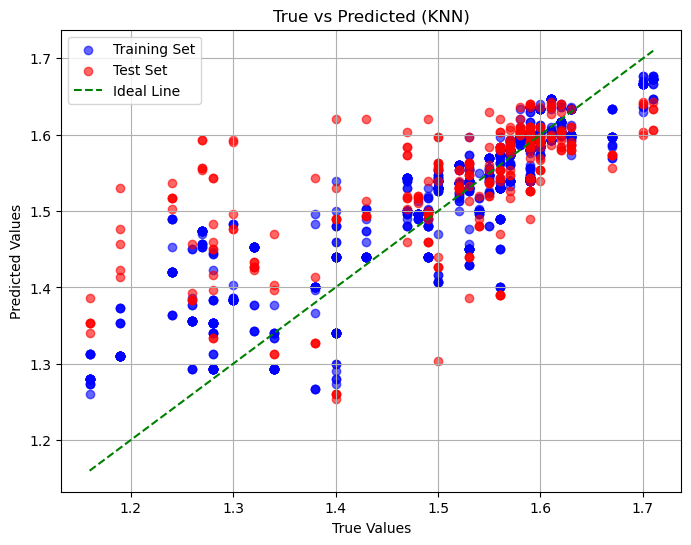

In [8]:
from sklearn.neighbors import KNeighborsRegressor

# Define the KNN model
knn = KNeighborsRegressor(
    n_neighbors=3,         # Number of neighbors to use
    weights='uniform',     # Weight function used in prediction ('uniform' or 'distance')
    algorithm='auto',      # Algorithm used to compute the nearest neighbors
    leaf_size=30,          # Leaf size passed to BallTree or KDTree
    p=1
)

# Training and evaluation of the machine learning model
knn_metrics = train_evaluate_model(knn, "KNN", X, y, num_repeats=5, num_folds=5)


=== GPR Performance ===
Train R² Mean: 0.9883, Std: 0.0013
Train RMSE Mean: 0.0138, Std: 0.0011
Train MAE Mean: 0.0110, Std: 0.0009
Train MSE Mean: 0.0002, Std: 0.0000
Train MRE Mean: 0.7410%, Std: 0.0604%
Test R² Mean: 0.4509, Std: 0.1875
Test RMSE Mean: 0.0882, Std: 0.0267
Test MAE Mean: 0.0632, Std: 0.0184
Test MSE Mean: 0.0085, Std: 0.0050
Test MRE Mean: 4.5605%, Std: 1.5014%


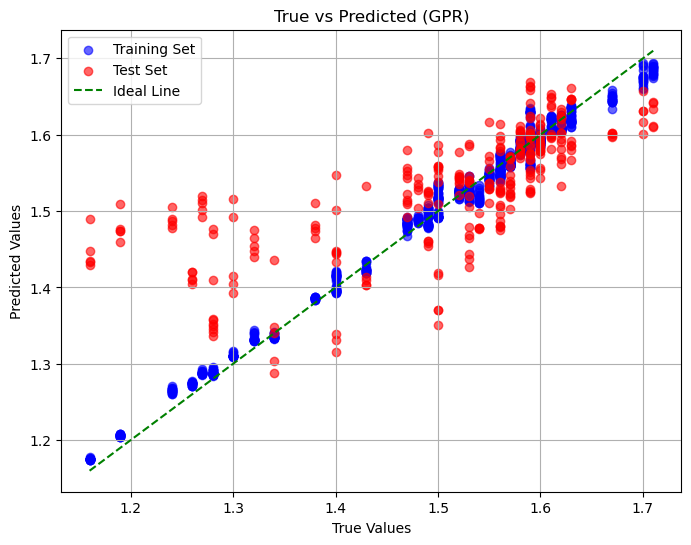

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Define the machine learning model
kernel = Matern(length_scale=1.0, nu=1.5) 
gpr = GaussianProcessRegressor(
    kernel=kernel,                     
    alpha=0.05,                        
    n_restarts_optimizer=20,          
    normalize_y=True                 
)

# Training and evaluation of the machine learning model
gpr_metrics = train_evaluate_model(gpr, "GPR", X, y, num_repeats=5, num_folds=5)


=== SVR Performance ===
Train R² Mean: 0.9761, Std: 0.0043
Train RMSE Mean: 0.0196, Std: 0.0012
Train MAE Mean: 0.0147, Std: 0.0008
Train MSE Mean: 0.0004, Std: 0.0000
Train MRE Mean: 0.9680%, Std: 0.0520%
Test R² Mean: 0.5891, Std: 0.1970
Test RMSE Mean: 0.0733, Std: 0.0160
Test MAE Mean: 0.0542, Std: 0.0115
Test MSE Mean: 0.0056, Std: 0.0023
Test MRE Mean: 3.8222%, Std: 0.8962%


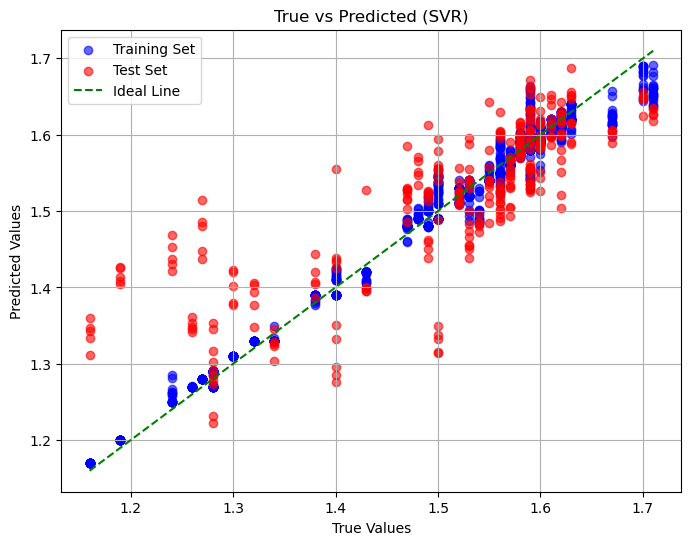

In [21]:
from sklearn.svm import SVR  
svr = SVR(kernel='rbf', C=1, epsilon=0.01,)
SVR_metrics = train_evaluate_model(svr, "SVR", X, y, num_repeats=5, num_folds=5)


=== mlp Performance ===
Train R² Mean: 0.9196, Std: 0.0152
Train RMSE Mean: 0.0359, Std: 0.0028
Train MAE Mean: 0.0280, Std: 0.0026
Train MSE Mean: 0.0013, Std: 0.0002
Train MRE Mean: 1.8935%, Std: 0.1778%
Test R² Mean: 0.1976, Std: 0.5171
Test RMSE Mean: 0.1003, Std: 0.0315
Test MAE Mean: 0.0692, Std: 0.0224
Test MSE Mean: 0.0110, Std: 0.0069
Test MRE Mean: 4.8811%, Std: 1.6330%


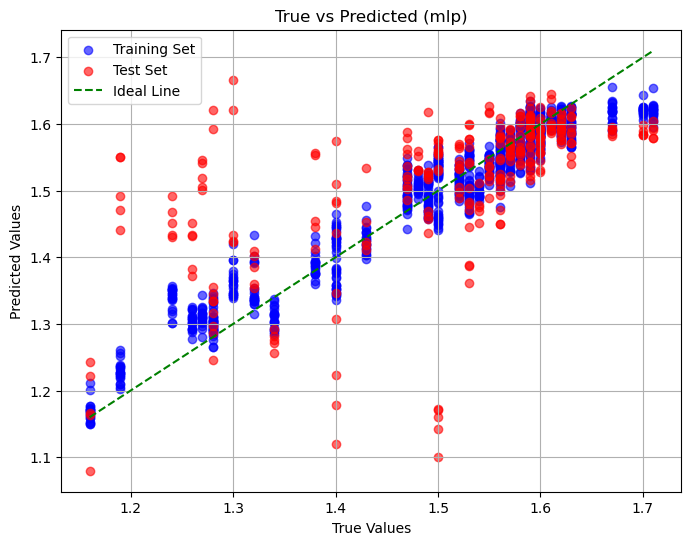

In [29]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=42, learning_rate_init = 0.005, learning_rate='adaptive',
             hidden_layer_sizes=(200, 500), alpha=0.05, activation='relu', max_iter=1000)
mlp_metrics = train_evaluate_model(mlp, "mlp", X, y, num_repeats=5, num_folds=5)

In [29]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 使用 tf.keras 导入
Sequential = tf.keras.Sequential
InputLayer = tf.keras.layers.InputLayer
Dense = tf.keras.layers.Dense
EarlyStopping = tf.keras.callbacks.EarlyStopping
Adam = tf.keras.optimizers.Adam

# 设置随机种子确保结果可复现
tf.keras.utils.set_random_seed(42)

# 构建贝叶斯神经网络模型
def build_bayesian_model(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    
    x = tfpl.DenseFlipout(128, activation='relu')(inputs)
    x = tfpl.DenseFlipout(64, activation='relu')(x)
    
    # 输出两维：均值 和 标准差参数
    x = tfpl.DenseFlipout(2)(x)
    
    # 构建概率分布输出层
    outputs = tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1], 
                             scale=tf.math.softplus(t[..., 1:]) + 1e-6)
    )(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    def neg_log_likelihood(y_true, y_pred_dist):
        return -y_pred_dist.log_prob(tf.squeeze(y_true))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=neg_log_likelihood,
                  metrics=['mae'])
    return model


# 包装成 scikit-learn 接口
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.metrics import r2_score

class BayesianNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=100, batch_size=32, verbose=0, patience=10):
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.patience = patience
        self.model = None

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        tf.keras.backend.clear_session()

        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        self.model = build_bayesian_model(X.shape[1])

        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=self.patience,
            restore_best_weights=True,
            min_delta=0.001
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.1, random_state=42
        )

        self.model.fit(
            X_train, y_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=self.verbose
        )
        return self

    def predict(self, X):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        preds_dist = self.model(X)
        preds = preds_dist.mean().numpy().flatten()
        return preds

    def predict_with_uncertainty(self, X, n_samples=100):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        preds = np.array([self.model(X).sample().numpy().flatten() for _ in range(n_samples)])
        mean_preds = np.mean(preds, axis=0)
        std_preds = np.std(preds, axis=0)
        return mean_preds, std_preds

    def score(self, X, y):
        preds = self.predict(X)
        return r2_score(y, preds)
# 构建贝叶斯神经网络模型实例
bnn_model = BayesianNNRegressor(epochs=200, batch_size=8, verbose=1, patience=15)

# 调用评估函数（你已定义）
metrics = train_evaluate_model(bnn_model, "BayesianNN", X, y, num_repeats=3, num_folds=3)


AttributeError: 'tuple' object has no attribute 'rank'

In [ ]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# 定义贝叶斯神经网络结构
class BayesianRegression(PyroModule):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        self.fc1 = PyroModule[nn.Linear](input_dim, 128)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([128, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([128]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](128, 64)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([64, 128]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([64]).to_event(1))

        self.out = PyroModule[nn.Linear](64, 1)
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([1, 64]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))

        # 观测噪声的标准差（自由参数）
        self.log_noise = PyroSample(dist.Normal(-1., 0.1))

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.out(x).squeeze(-1)
        sigma = torch.exp(self.log_noise)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean


# 引导函数（均值场）
def make_guide(model):
    return pyro.infer.autoguide.AutoDiagonalNormal(model)


# Sklearn 风格包装器
class BayesianNNRegressorTorch(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=1000, lr=0.01, batch_size=32, verbose=True):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

        self.model = BayesianRegression(input_dim=X.shape[1])
        self.guide = make_guide(self.model)
        self.optimizer = Adam({"lr": self.lr})
        self.svi = SVI(self.model, self.guide, self.optimizer, loss=Trace_ELBO())

        pyro.clear_param_store()
        for epoch in range(self.epochs):
            loss = self.svi.step(X_train, y_train)
            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"[{epoch+1}/{self.epochs}] Loss: {loss:.4f}")
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=100)
        samples = predictive(X)
        pred_mean = samples['obs'].mean(axis=0).detach().numpy()
        return pred_mean

    def predict_with_uncertainty(self, X, n_samples=100):
        X = torch.tensor(X, dtype=torch.float32)
        predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=n_samples)
        samples = predictive(X)
        pred_samples = samples['obs'].detach().numpy()
        return pred_samples.mean(axis=0), pred_samples.std(axis=0)

    def score(self, X, y):
        preds = self.predict(X)
        return r2_score(y, preds)


# 构建模型
bnn_torch = BayesianNNRegressorTorch(epochs=1000, lr=0.01, batch_size=32, verbose=True)

# 假设你已有 X, y
metrics = train_evaluate_model(bnn_torch, "BayesianTorch", X, y, num_repeats=5, num_folds=5)

[100/1000] Loss: 11249.1974
[200/1000] Loss: 6504.7621
[300/1000] Loss: 3926.5083
[400/1000] Loss: 2671.3389
[500/1000] Loss: 2047.8995
[600/1000] Loss: 1612.4646
[700/1000] Loss: 1280.6194
[800/1000] Loss: 1074.6281
[900/1000] Loss: 910.3632
[1000/1000] Loss: 865.3949


ValueError: could not determine the shape of object type 'DataFrame'


=== dt Performance ===
Train R² Mean: 0.9231, Std: 0.0218
Train RMSE Mean: 0.0350, Std: 0.0046
Train MAE Mean: 0.0271, Std: 0.0030
Train MSE Mean: 0.0012, Std: 0.0004
Train MRE Mean: 1.8264%, Std: 0.2174%
Test R² Mean: 0.6689, Std: 0.3433
Test RMSE Mean: 0.0605, Std: 0.0267
Test MAE Mean: 0.0447, Std: 0.0174
Test MSE Mean: 0.0044, Std: 0.0044
Test MRE Mean: 3.0909%, Std: 1.2375%


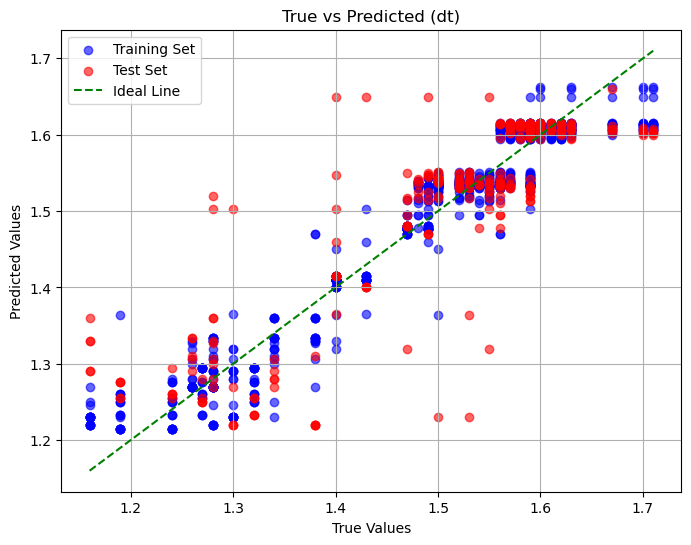

In [8]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=2, min_samples_split=2)
dt = train_evaluate_model(dt, "dt", X, y, num_repeats=5, num_folds=5)


=== extra_tree Performance ===
Train R² Mean: 0.9504, Std: 0.0094
Train RMSE Mean: 0.0282, Std: 0.0022
Train MAE Mean: 0.0209, Std: 0.0016
Train MSE Mean: 0.0008, Std: 0.0001
Train MRE Mean: 1.3708%, Std: 0.1084%
Test R² Mean: 0.6870, Std: 0.1874
Test RMSE Mean: 0.0631, Std: 0.0174
Test MAE Mean: 0.0476, Std: 0.0136
Test MSE Mean: 0.0043, Std: 0.0025
Test MRE Mean: 3.3365%, Std: 1.0203%


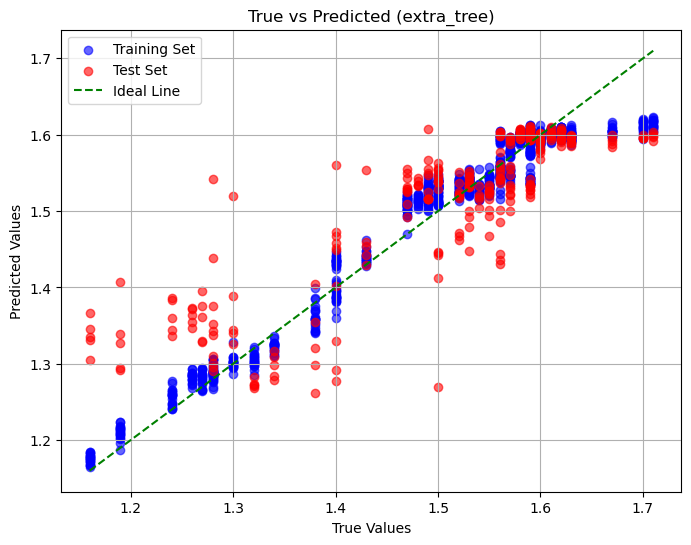

In [4]:
from sklearn.ensemble import ExtraTreesRegressor
extra_tree = ExtraTreesRegressor(n_estimators=500, max_depth=5, min_samples_split=3,min_samples_leaf=1,random_state=1)
extra_tree = train_evaluate_model(model=extra_tree,model_name="extra_tree",X=X,y=y,num_repeats=5,num_folds=5)


=== rf Performance ===
Train R² Mean: 0.9157, Std: 0.0166
Train RMSE Mean: 0.0367, Std: 0.0024
Train MAE Mean: 0.0270, Std: 0.0015
Train MSE Mean: 0.0014, Std: 0.0002
Train MRE Mean: 1.8925%, Std: 0.1145%
Test R² Mean: 0.7250, Std: 0.1707
Test RMSE Mean: 0.0596, Std: 0.0185
Test MAE Mean: 0.0442, Std: 0.0137
Test MSE Mean: 0.0039, Std: 0.0024
Test MRE Mean: 3.1342%, Std: 1.0672%


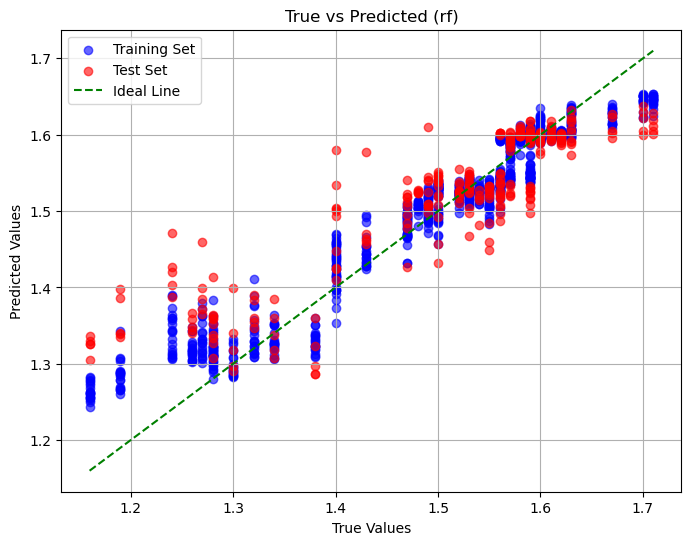

In [4]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_split=3,min_samples_leaf=2,random_state=1)
rf= train_evaluate_model(model=rf,model_name="rf",X=X,y=y,num_repeats=5,num_folds=5)


=== xgb Performance ===
Train R² Mean: 0.9822, Std: 0.0035
Train RMSE Mean: 0.0173, Std: 0.0016
Train MAE Mean: 0.0137, Std: 0.0013
Train MSE Mean: 0.0003, Std: 0.0001
Train MRE Mean: 0.9478%, Std: 0.0952%
Test R² Mean: 0.8018, Std: 0.1265
Test RMSE Mean: 0.0528, Std: 0.0111
Test MAE Mean: 0.0419, Std: 0.0083
Test MSE Mean: 0.0029, Std: 0.0012
Test MRE Mean: 2.9543%, Std: 0.6420%


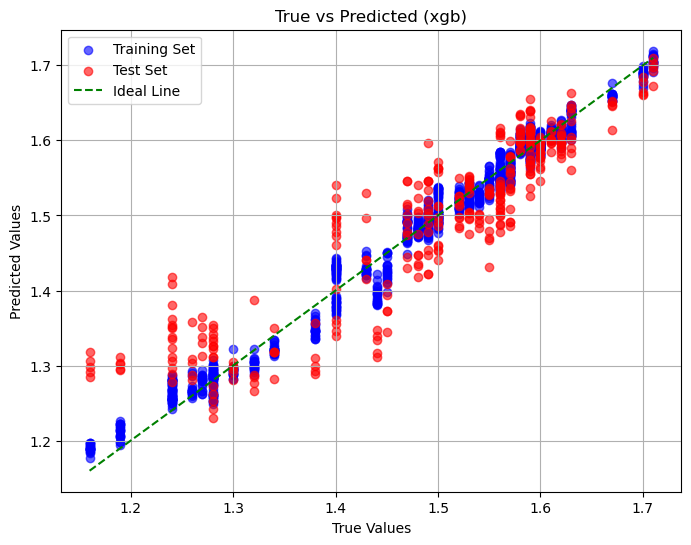

In [3]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=240, reg_lambda=10, reg_alpha=0,
                   min_child_weight=3, subsample=0.8, colsample_bytree=0.6)
xgb = train_evaluate_model(xgb, "xgb", X, y, num_repeats=5, num_folds=5)


=== gbdt Performance ===
Train R² Mean: 0.9981, Std: 0.0008
Train RMSE Mean: 0.0055, Std: 0.0008
Train MAE Mean: 0.0041, Std: 0.0007
Train MSE Mean: 0.0000, Std: 0.0000
Train MRE Mean: 0.2675%, Std: 0.0458%
Test R² Mean: 0.7875, Std: 0.1648
Test RMSE Mean: 0.0511, Std: 0.0186
Test MAE Mean: 0.0407, Std: 0.0131
Test MSE Mean: 0.0030, Std: 0.0027
Test MRE Mean: 2.8502%, Std: 1.0275%


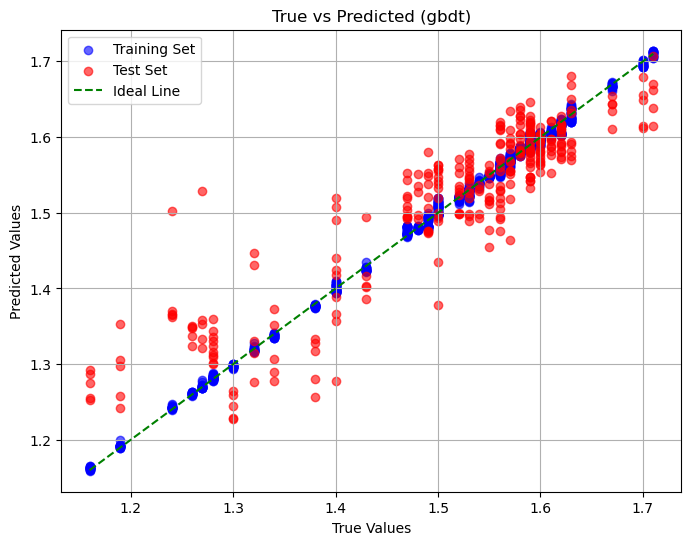

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
# Step 1: 定义 GBDT 模型
gbdt = GradientBoostingRegressor(
    max_depth=5,               # 树的最大深度
    learning_rate=0.1,         # 学习率（步长）
    n_estimators=200,          # 弱学习器的数量（树的个数）
    min_samples_split=5,       # 内部节点再划分所需的最小样本数
    min_samples_leaf=3,        # 叶子节点所需的最小样本数
    subsample=0.8,             # 训练每棵树使用的样本比例（开启随机梯度提升）
    loss='squared_error',      # 回归任务使用平方误差损失函数
    random_state=42
)

gbdt = train_evaluate_model(gbdt, "gbdt", X, y, num_repeats=5, num_folds=5)


=== adaboost Performance ===
Train R² Mean: 0.9828, Std: 0.0030
Train RMSE Mean: 0.0166, Std: 0.0011
Train MAE Mean: 0.0117, Std: 0.0009
Test R² Mean: 0.7749, Std: 0.2245
Test RMSE Mean: 0.0504, Std: 0.0161
Test MAE Mean: 0.0391, Std: 0.0120


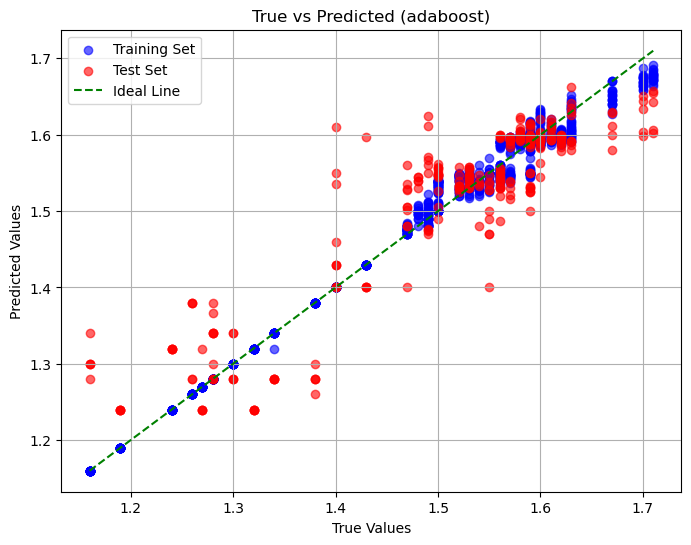

In [19]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
base_estimator = DecisionTreeRegressor(max_depth=5)  # 设置基础学习器为深度为3的决策树

# Step 2: 定义 AdaBoost 模型
adaboost = AdaBoostRegressor(
    estimator=base_estimator,  # 使用上面定义的基础学习器
    n_estimators=240,               # 弱学习器的数量
    learning_rate=0.1,              # 学习率
    loss='square',                  # 可选 'linear', 'square', 'exponential'
    random_state=42
)
adaboost = train_evaluate_model(adaboost, "adaboost", X, y, num_repeats=5, num_folds=5)


Training Set - R2 Score 0.9737965681896332
Training Set - std R2 Score 0.0022049628149432756
Training Set - RMSE 0.02121561801388634
Training Set - std RMSE Score 0.001041609867284785
Training Set - MAE 0.01706122965812683
Training Set - std MAE Score 0.0008096488342092696
Test Set - R2 Score 0.8366587457418467
Test Set - std R2 Score 0.04978162720209118
Test Set - RMSE 0.04914344171361104
Test Set - std RMSE Score 0.009356965788552439
Test Set - MAE 0.04057936761220296
Test Set - std MAE Score 0.00833216637140016
Test Set - MAE (y < 1.50) 0.05351456091677816
Test Set - std MAE (y < 1.50) 0.013821870420324388


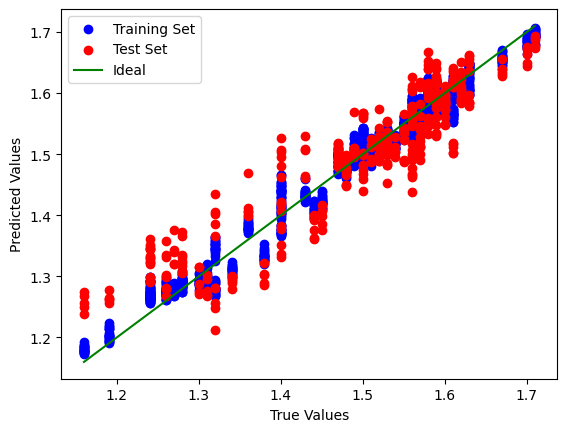

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load data from Excel file
data = pd.read_excel('Total_data.xlsx')


X = data.iloc[:, :5]   
y = data.iloc[:, 5]    
feature_names = ['x1', 'x2', 'x3', 'x4', 'x5']

# Initialize XGBoost Regressor
xgb = XGBRegressor(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=240,
    reg_lambda=5,
    reg_alpha=0.01,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.5
)

# Define number of repeated cross-validation loops and folds
num_repeats = 5
num_folds = 5

# Initialize lists to store evaluation metrics
all_r2_train = []
all_rmse_train = []
all_mae_train = []
all_r2_test = []
all_rmse_test = []
all_mae_test = []
all_y_train = []
all_y_train_pred = []
all_y_test = []
all_y_test_pred = []
all_x_train = []
all_x_test = []
all_mae_test_y_lt_150 = []  

model_rf_results = []

# K-repeated K-Fold Cross Validator
for i in range(num_repeats):

    
    cv = KFold(n_splits=num_folds, shuffle=True, random_state=i)

    
    for train_index, test_index in cv.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = xgb.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)

        y_test_pred = model.predict(X_test)

        all_y_train.append(y_train)
        all_y_train_pred.append(y_train_pred)
        all_y_test.append(y_test)
        all_y_test_pred.append(y_test_pred)
        all_x_train.append(X_train)
        all_x_test.append(X_test)

        # Calculate evaluation metrics
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)

        all_r2_train.append(r2_train)
        all_rmse_train.append(rmse_train)
        all_mae_train.append(mae_train)
        all_r2_test.append(r2_test)
        all_rmse_test.append(rmse_test)
        all_mae_test.append(mae_test)
        
        y_test_lt_150 = y_test < 1.50
        if np.any(y_test_lt_150):  
            mae_test_y_lt_150 = mean_absolute_error(y_test[y_test_lt_150], y_test_pred[y_test_lt_150])
            all_mae_test_y_lt_150.append(mae_test_y_lt_150)

# Calculate mean and standard deviation of evaluation metrics
mean_r2_train = np.mean(all_r2_train)
std_r2_train = np.std(all_r2_train)
mean_rmse_train = np.mean(all_rmse_train)
std_rmse_train = np.std(all_rmse_train)
mean_mae_train = np.mean(all_mae_train)
std_mae_train = np.std(all_mae_train)

mean_r2_test = np.mean(all_r2_test)
std_r2_test = np.std(all_r2_test)
mean_rmse_test = np.mean(all_rmse_test)
std_rmse_test = np.std(all_rmse_test)
mean_mae_test = np.mean(all_mae_test)
std_mae_test = np.std(all_mae_test)


mean_mae_test_y_lt_150 = np.mean(all_mae_test_y_lt_150)
std_mae_test_y_lt_150 = np.std(all_mae_test_y_lt_150)

print("\nTraining Set - R2 Score", mean_r2_train)
print("Training Set - std R2 Score", std_r2_train)
print("Training Set - RMSE", mean_rmse_train)
print("Training Set - std RMSE Score", std_rmse_train)
print("Training Set - MAE", mean_mae_train)
print("Training Set - std MAE Score", std_mae_train)
print("Test Set - R2 Score", mean_r2_test)
print("Test Set - std R2 Score", std_r2_test)
print("Test Set - RMSE", mean_rmse_test)
print("Test Set - std RMSE Score", std_rmse_test)
print("Test Set - MAE", mean_mae_test)
print("Test Set - std MAE Score", std_mae_test)
print("Test Set - MAE (y < 1.50)", mean_mae_test_y_lt_150)
print("Test Set - std MAE (y < 1.50)", std_mae_test_y_lt_150)


# Plot predicted vs true values
y_train_combined = np.concatenate(all_y_train)
y_train_pred_combined = np.concatenate(all_y_train_pred)
y_test_combined = np.concatenate(all_y_test)
y_test_pred_combined = np.concatenate(all_y_test_pred)
x_test_combined = np.concatenate(all_x_test)
x_train_combined = np.concatenate(all_x_train)
plt.scatter(y_train_combined, y_train_pred_combined, color='blue', label='Training Set')
plt.scatter(y_test_combined, y_test_pred_combined, color='red', label='Test Set')
plt.plot([min(y_train_combined), max(y_train_combined)], [min(y_train_combined), max(y_train_combined)], color='green', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


# Save prediction results into DataFrames
train_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_train_combined],
        'True_Y': y_train_combined,
        'Predicted_Y': y_train_pred_combined
    })

test_data = pd.DataFrame({
        'Conditions': [','.join(map(str, row)) for row in x_test_combined],
        'True_Y': y_test_combined,
        'Predicted_Y': y_test_pred_combined
    })

    # Export to Excel with model name included in filename
# train_data.to_excel(f'train_predictions_xgb_all_data_col=0.5.xlsx', index=False)
# test_data.to_excel(f'test_predictions_xgb_all_data_col=0.5.xlsx', index=False)